<a href="https://colab.research.google.com/github/gopal2812/mlblr/blob/master/assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import AveragePooling2D, Input, Flatten
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import sys
import keras
import imutils

Using TensorFlow backend.


In [2]:
!pip install git+https://github.com/qubvel/classification_models.git
from classification_models.resnet import ResNet18, preprocess_input

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-qw4mmjdw
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-qw4mmjdw
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-vc_gjaa8/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
n_classes=10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
nb_train_samples=x_train.__len__()
nb_valid_samples=x_test.__len__()

#Resizing Required
#x_train_resize = np.array([cv2.resize(img.transpose(1,2,0), (227,227)).transpose(2,0,1) for img in x_train[:nb_train_samples,:,:,:]])
#x_valid_resize = np.array([cv2.resize(img.transpose(1,2,0), (227,227)).transpose(2,0,1) for img in x_valid[:nb_valid_samples,:,:,:]])

(128, 128, 3)


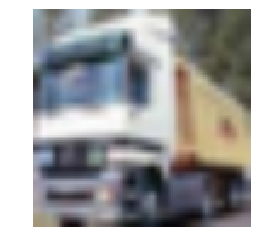

In [4]:
def display_image(img):
 img = cv2.resize(img,(128,128))
 print(img.shape)
 plt.imshow(img)
 plt.axis('off')
    
display_image(x_train[1])

In [5]:
# Input image dimensions.
input_shape = x_train.shape[1:]
x_test_orig = x_test
x_train_orig = x_train

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Do subtract pixel
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train_orig=y_train
y_test_orig=y_test
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [6]:
image_model= ResNet18((32, 32, 3), include_top= False, weights='imagenet') 
#image_model.summary()
x = keras.layers.GlobalAveragePooling2D()(image_model.output)
output = keras.layers.Dense(n_classes, activation='softmax',name='predictions')(x)

model = keras.models.Model(input=image_model.input, outputs=[output])
model.summary()
model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.SGD(), metrics=["accuracy"])

W0710 15:23:52.010272 139690544482176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 15:23:52.048855 139690544482176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 15:23:52.050668 139690544482176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0710 15:23:52.052435 139690544482176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0710 15:23:52.054120 139690

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [7]:
batch_size = 128
epochs = 10
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test))


W0710 15:24:02.503501 139690544482176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 45s 907us/step - loss: 1.1834 - acc: 0.5959 - val_loss: 0.8941 - val_acc: 0.6917
Epoch 2/10
50000/50000 [==============================] - 41s 810us/step - loss: 0.7317 - acc: 0.7438 - val_loss: 0.7631 - val_acc: 0.7357
Epoch 3/10
50000/50000 [==============================] - 40s 806us/step - loss: 0.5803 - acc: 0.7965 - val_loss: 0.7156 - val_acc: 0.7561
Epoch 4/10
50000/50000 [==============================] - 40s 806us/step - loss: 0.4598 - acc: 0.8414 - val_loss: 0.7184 - val_acc: 0.7613
Epoch 5/10
50000/50000 [==============================] - 40s 805us/step - loss: 0.3644 - acc: 0.8753 - val_loss: 0.7209 - val_acc: 0.7701
Epoch 6/10
50000/50000 [==============================] - 40s 806us/step - loss: 0.2830 - acc: 0.9051 - val_loss: 0.7406 - val_acc: 0.7716
Epoch 7/10
50000/50000 [==============================] - 40s 805us/step - loss: 0.2164 - acc: 0.9298 - val_loss: 0.

In [8]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 6s 562us/step
Test loss: 0.8909666871070862
Test accuracy: 0.772


In [0]:
def convertCIFER10Data(image):
    img = image.astype('float32') / 255
    print(img.shape)
    #img /= 255
    #c = np.zeros(32*32*3).reshape((1,32,32,3))
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    #c[0] = img
    #return c
    return img

#i=convertCIFER10Data(x_test[1])
#print(i.shape)

In [23]:
!ls -l ../


total 100
drwxr-xr-x   1 root root 4096 Jul  3 16:08 bin
drwxr-xr-x   2 root root 4096 Apr 24  2018 boot
drwxr-xr-x   1 root root 4096 Jul  3 16:14 content
drwxr-xr-x   1 root root 4096 Jul  8 16:06 datalab
drwxr-xr-x   5 root root  440 Jul 10 14:10 dev
drwxr-xr-x   1 root root 4096 Jul 10 14:10 etc
drwxr-xr-x   2 root root 4096 Apr 24  2018 home
drwxr-xr-x   1 root root 4096 Jul  3 16:10 lib
drwxr-xr-x   2 root root 4096 Jul  3 16:06 lib32
drwxr-xr-x   2 root root 4096 Jun 12 16:55 lib64
drwxr-xr-x   2 root root 4096 Jun 12 16:54 media
drwxr-xr-x   2 root root 4096 Jun 12 16:54 mnt
drwxr-xr-x   1 root root 4096 Jul 10 14:10 opt
dr-xr-xr-x 110 root root    0 Jul 10 14:10 proc
drwx------   1 root root 4096 Jul 10 14:17 root
drwxr-xr-x   1 root root 4096 Jul  3 16:08 run
drwxr-xr-x   1 root root 4096 Jul  3 16:09 sbin
drwxr-xr-x   2 root root 4096 Jun 12 16:54 srv
drwxr-xr-x   4 root root 4096 Jul  8 16:05 swift
dr-xr-xr-x  12 root root    0 Jul 10 14:10 sys
drwxr-xr-x   1 root root 4096

(32, 32, 3)
(1, 32, 32, 3)
[5]
3355
heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[2]
3319


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[2]
1507
heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[2]
3514
heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[7]
2358
heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[4]
(32, 32, 3)
(1, 32, 32, 3)
[4]
(32, 32, 3)
(1, 32, 32, 3)
[5]
(32, 32, 3)
(1, 32, 32, 3)
[0]
3429
heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[3]
5506
heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[0]
(32, 32, 3)
(1, 32, 32, 3)
[9]
(32, 32, 3)
(1, 32, 32, 3)
[2]
4101
heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[3]
(32, 32, 3)
(1, 32, 32, 3)
[3]
8491
heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[3]
(32, 32, 3)
(1, 32, 32, 3)
[3]
4760
heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[6]
5977
heatmap +  (2, 2)
(32, 32, 3) (32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)
[8]
985
heat

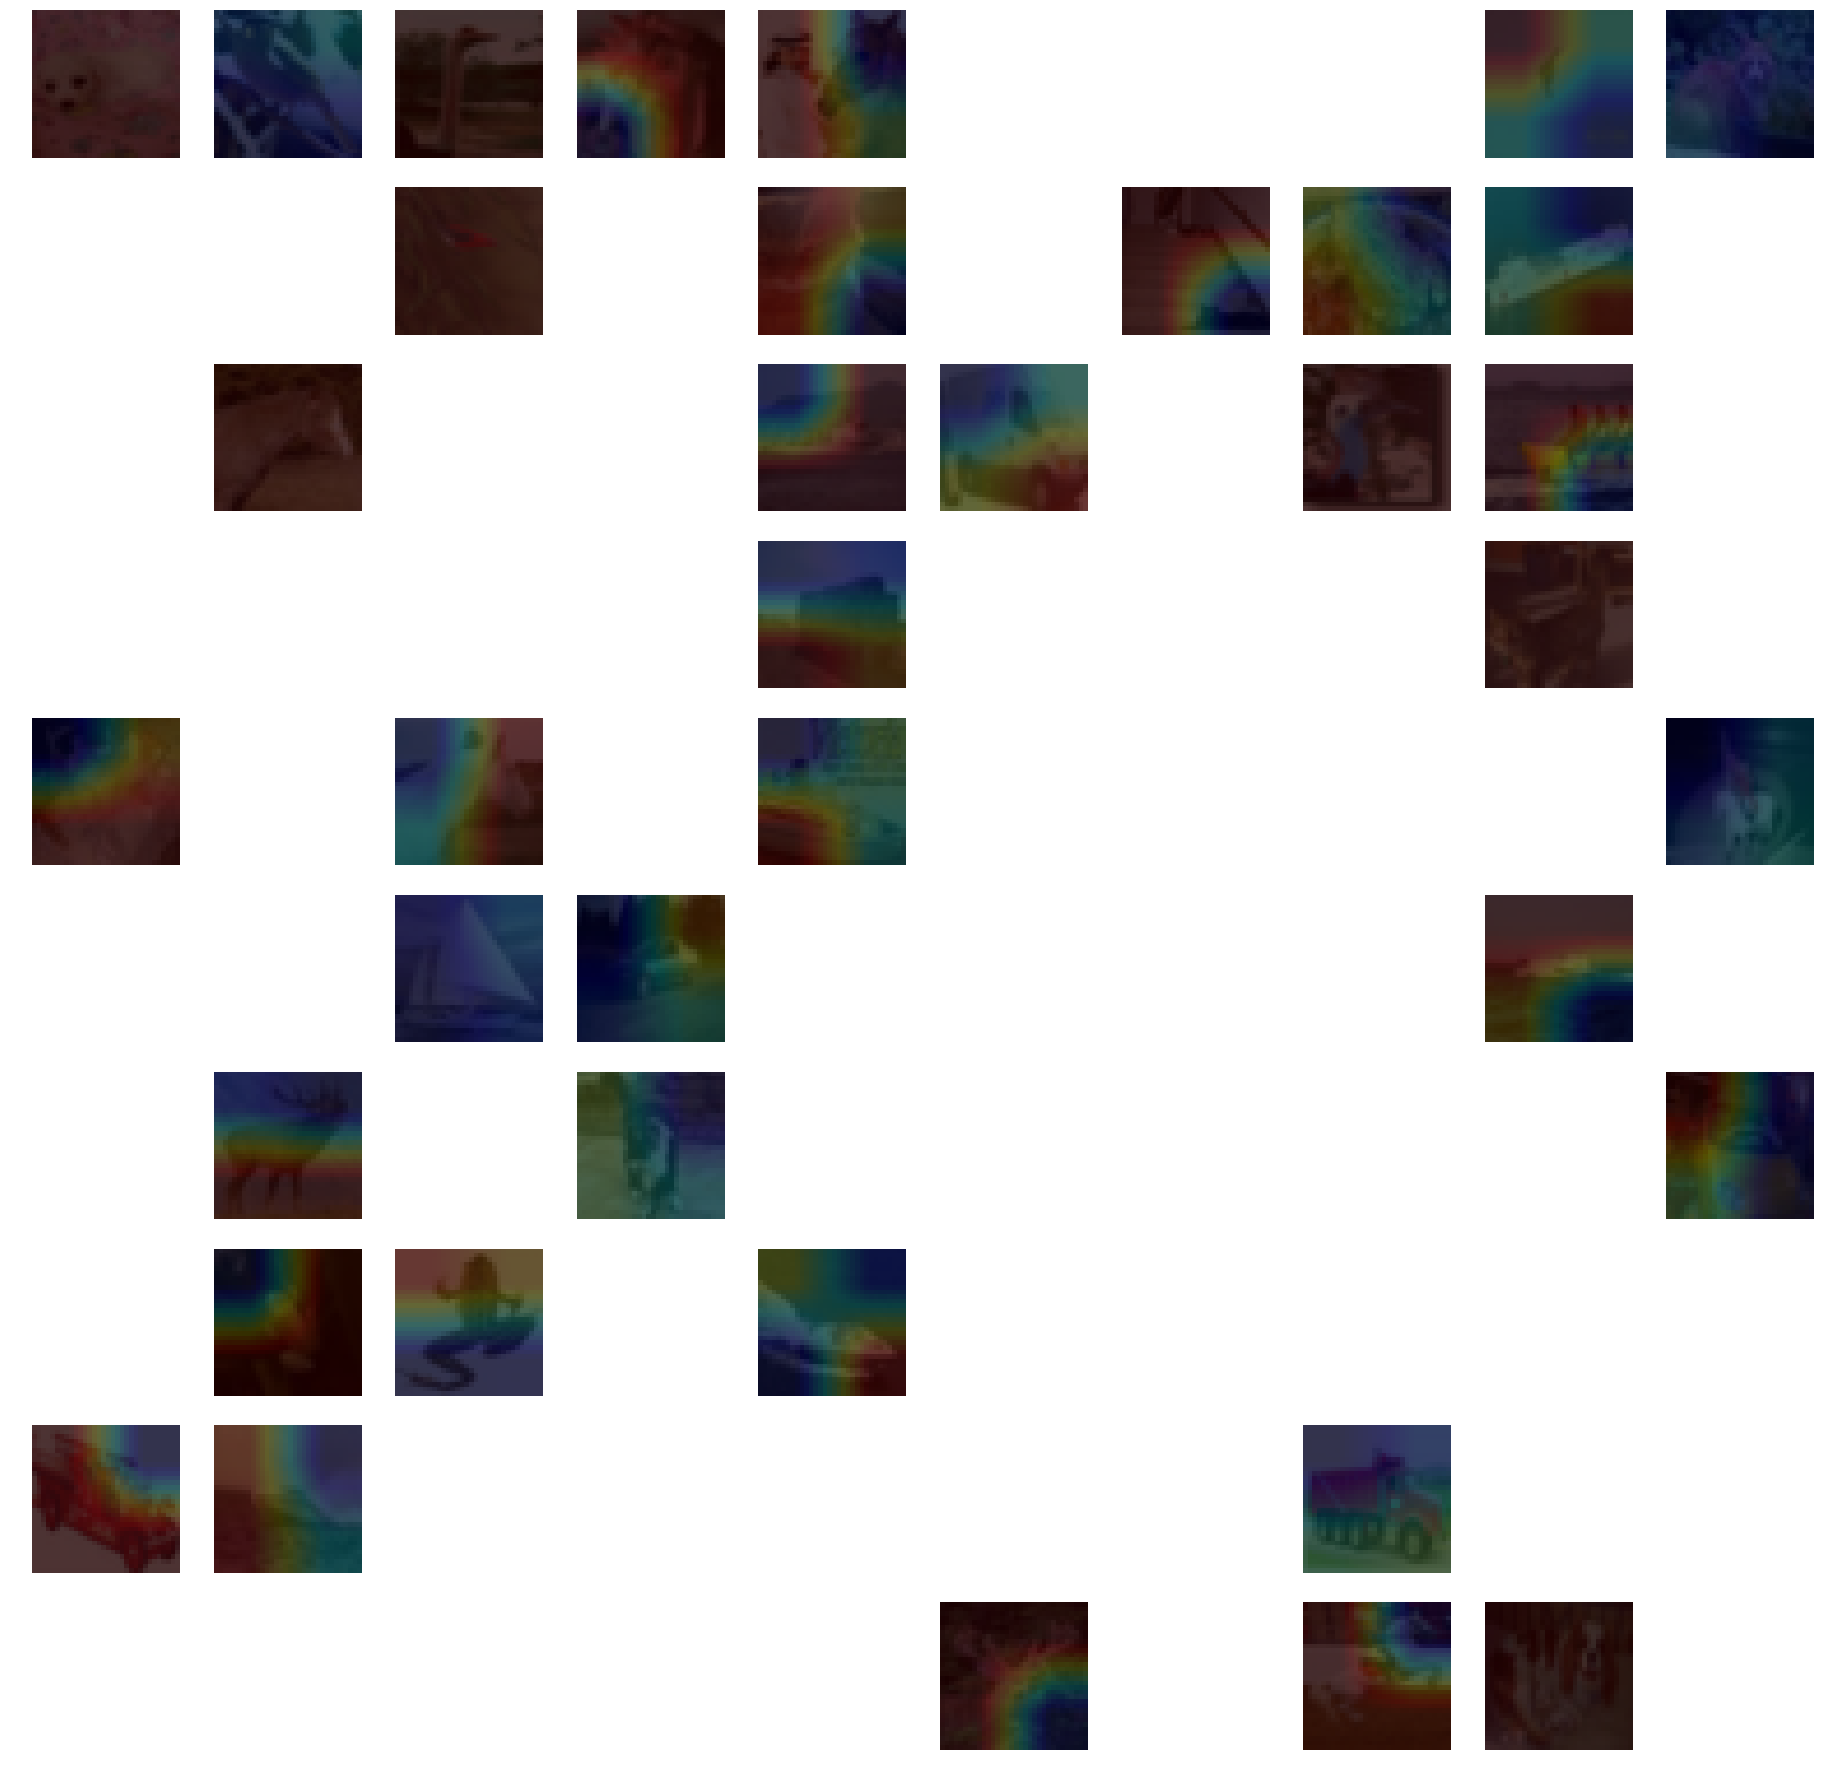

In [13]:
def show_image(val):
  plt.figure(figsize=(32,32))
  right = 0
  mistake = 0
  for i in range(val):
    index = random.randint(0, x_test_orig.shape[0])
    image = x_test_orig[index]
    data = convertCIFER10Data(image)

    plt.subplot(10, 10, i+1)
    #plt.imshow(image)
    plt.axis('off')
    ret = model.predict(data, batch_size=1) 
    #print(ret)

    bestnum = 0.0
    bestclass = 0
    for n in [0,1,2,3,4,5,6,7,8,9]:
        if bestnum < ret[0][n]:
            bestnum = ret[0][n]
            bestclass = n
    print(y_test_orig[index])
        

    if y_test_orig[index] == bestclass:
        #plt.title(cifar10_labels[bestclass])
        right += 1
    else:
        print(index)
        class_output = model.output[:, bestclass]
        last_conv_layer = model.get_layer("stage3_unit2_conv1")
        grads = K.gradients(class_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
        
        pooled_grads_value, conv_layer_output_value = iterate([data])
        for i in range(256):
          conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
          
        heatmap = np.mean(conv_layer_output_value, axis=-1)
        print("heatmap + ",heatmap.shape)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        #
        #img = cv2.imread(img_path)
        image =x_test_orig[index]
        #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        #heatmap= import imutils.resize(heatmap.transpose(1,2,0), (image.shape[1],image.shape[0])).transpose(2,0,1)
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        #heatmap = image.img_to_array(heatmap)
        #heatmap = imutils.resize(heatmap,image.shape[0] , inter=cv2.INTER_CUBIC)
        heatmap = np.uint8(255 * heatmap)
        #print(image.shape, heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        print(image.shape, heatmap.shape)
        superimposed_img = cv2.addWeighted(image, 0.2, heatmap, 0.2, 0)
        #plt.imshow( image)
        plt.imshow(superimposed_img)
        #cv2.waitKey(0)
        
        #plt.title(cifar10_labels[bestclass] + "!=" + cifar10_labels[y_test[index][0]], color='#ff0000')
        mistake += 1
  print(right,mistake)
  
show_image(100)


In [0]:


#preds = model.predict(x)
#class_idx = np.argmax(preds[0])
#print(class_idx)
print(model.output.shape)
class_output = model.output[:, 5]
last_conv_layer = model.get_layer("stage4_unit2_conv2")

4 96
(?, 10)


In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x_test])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)


In [0]:
#img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]),interpolation = cv2.INTER_AREA)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
cv2_imshow( image)
cv2_imshow(superimposed_img)
cv2.waitKey(0)

NameError: ignored